In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
df_patient = pd.read_csv('data/icu_cohort_small.csv')
df_patient

,stay_id,hadm_id,subject_id,intime,outtime,icu_los_hours,gender,anchor_age,died_in_hosp
0,37302156,21819818,11417989,2140-11-02 21:07:10,2140-11-02 21:13:32,0,F,31,0
1,33255415,27790400,13941452,2161-05-21 19:34:30,2161-05-21 19:38:40,0,F,33,0
2,34040970,20991814,13447872,2140-12-21 23:12:50,2140-12-21 23:41:20,0,F,34,0
3,36502717,26958979,11331147,2142-05-14 20:10:54,2142-05-14 20:40:34,0,F,43,0
4,33084533,22087634,10971284,2189-05-19 18:42:21,2189-05-19 18:47:20,0,F,48,0
...,...,...,...,...,...,...,...,...,...
94439,31492392,24012265,18503414,2130-09-25 00:38:38,2131-01-30 21:28:57,3069,M,87,1
94440,30359303,26571961,11633737,2187-05-15 21:22:40,2187-09-28 22:04:32,3265,M,48,0
94441,39510663,22329603,18744840,2114-05-26 19:00:32,2114-10-13 20:17:49,3361,F,29,0
94442,36307509,24784126,11336222,2114-01-19 18:28:25,2114-06-28 10:28:37,3832,F,43,0


In [3]:
df_vital = pd.read_csv('data/vitals_ts_small.csv').sort_values(by=['stay_id', 'charttime'])
df_vital['charttime'] = pd.to_datetime(df_vital['charttime'])
df_vital

,stay_id,charttime,variable,value
11100415,30000153,2174-09-29 12:09:00,respiratory rate,18.0
8097302,30000153,2174-09-29 13:00:00,o2 saturation pulseoxymetry,100.0
8826274,30000153,2174-09-29 13:00:00,heart rate,104.0
9594399,30000153,2174-09-29 13:00:00,respiratory rate,16.0
5093009,30000153,2174-09-29 14:00:00,respiratory rate,16.0
...,...,...,...,...
1804833,39999858,2167-04-28 11:00:00,respiratory rate,18.0
10642233,39999858,2167-04-28 11:00:00,o2 saturation pulseoxymetry,98.0
6165405,39999858,2167-04-28 12:00:00,respiratory rate,12.0
7605102,39999858,2167-04-28 12:00:00,heart rate,66.0


In [9]:
# Analyze irregularity and missingness per patient
import numpy as np

# First, let's check what variables we have
print("Unique variables in the dataset:")
print(df_vital['variable'].unique())
print()

# Pivot the data to wide format for easier analysis
df_vital_pivot = df_vital.pivot_table(
    index=['stay_id', 'charttime'],
    columns='variable',
    values='value',
    aggfunc='first'
).reset_index()

print("Pivoted data columns:")
print(df_vital_pivot.columns.tolist())
print()

# Calculate metrics for each stay_id
irregularity_metrics = []

for stay_id in tqdm(df_vital_pivot['stay_id'].unique()):
    stay_data = df_vital_pivot[df_vital_pivot['stay_id'] == stay_id].copy()
    total_timepoints = len(stay_data)
    
    # Get column names (they might vary)
    cols = stay_data.columns.tolist()
    hr_col = [c for c in cols if 'heart' in c.lower()]
    rr_col = [c for c in cols if 'resp' in c.lower()]
    o2_col = [c for c in cols if 'o2' in c.lower() or 'oxygen' in c.lower()]
    
    # Calculate missingness
    heart_rate_present = stay_data[hr_col[0]].notna().sum() if hr_col else 0
    resp_rate_present = stay_data[rr_col[0]].notna().sum() if rr_col else 0
    o2sat_present = stay_data[o2_col[0]].notna().sum() if o2_col else 0
    
    # Total possible measurements across all three vitals
    total_possible = total_timepoints * 3
    total_present = heart_rate_present + resp_rate_present + o2sat_present
    missingness_rate = 1 - (total_present / total_possible)
    
    # Calculate irregularity (variance in time intervals)
    if len(stay_data) > 1:
        time_diffs = stay_data['charttime'].diff().dt.total_seconds() / 60  # in minutes
        time_irregularity = time_diffs.std() if len(time_diffs.dropna()) > 1 else 0
    else:
        time_irregularity = 0
    
    irregularity_metrics.append({
        'stay_id': stay_id,
        'total_timepoints': total_timepoints,
        'heart_rate_present': heart_rate_present,
        'resp_rate_present': resp_rate_present,
        'o2sat_present': o2sat_present,
        'missingness_rate': missingness_rate,
        'time_irregularity': time_irregularity,
        'combined_score': missingness_rate + time_irregularity / 1000  # normalized score
    })

irregularity_df = pd.DataFrame(irregularity_metrics)
irregularity_df = irregularity_df.sort_values('combined_score', ascending=False)

print("Top 10 patients with highest irregularity and missingness:")
print(irregularity_df.head(10))

# Select top 5 patients for visualization
top_patients = irregularity_df.head(5)['stay_id'].tolist()
print(f"\nSelected patients for visualization: {top_patients}")


Unique variables in the dataset:
['respiratory rate' 'o2 saturation pulseoxymetry' 'heart rate']

Pivoted data columns:
['stay_id', 'charttime', 'heart rate', 'o2 saturation pulseoxymetry', 'respiratory rate']



  0%|          | 0/94368 [00:00<?, ?it/s]

Top 10 patients with highest irregularity and missingness:
        stay_id  total_timepoints  heart_rate_present  resp_rate_present  \
20614  32193676                 3                   2                  2   
74024  37831531                 3                   3                  3   
24854  32634388                 3                   2                  3   
70802  37494825                 3                   2                  0   
87217  39249031                10                   3                  3   
50789  35393722                16                  12                 11   
40714  34308473                 8                   7                  7   
21828  32319140                21                   2                 18   
37406  33966130                 6                   4                  3   
11422  31202042                 4                   3                  2   

       o2sat_present  missingness_rate  time_irregularity  combined_score  
20614              2        

In [13]:
irregularity_df.head(20)

,stay_id,total_timepoints,heart_rate_present,resp_rate_present,o2sat_present,missingness_rate,time_irregularity,combined_score
20614,32193676,3,2,2,2,0.333333,1452.397329,1.785731
74024,37831531,3,3,3,1,0.222222,709.935208,0.932157
24854,32634388,3,2,3,3,0.111111,816.708332,0.927819
70802,37494825,3,2,0,2,0.555556,342.946789,0.898502
87217,39249031,10,3,3,7,0.566667,279.005824,0.845672
50789,35393722,16,12,11,12,0.270833,558.041328,0.828875
40714,34308473,8,7,7,7,0.125000,698.040216,0.823040
21828,32319140,21,2,18,2,0.650794,148.384423,0.799178
37406,33966130,6,4,3,3,0.444444,347.440211,0.791885
11422,31202042,4,3,2,1,0.500000,254.572190,0.754572


Text(0.5, 1.0, 'Respiratory Rate for Stay 39249031')

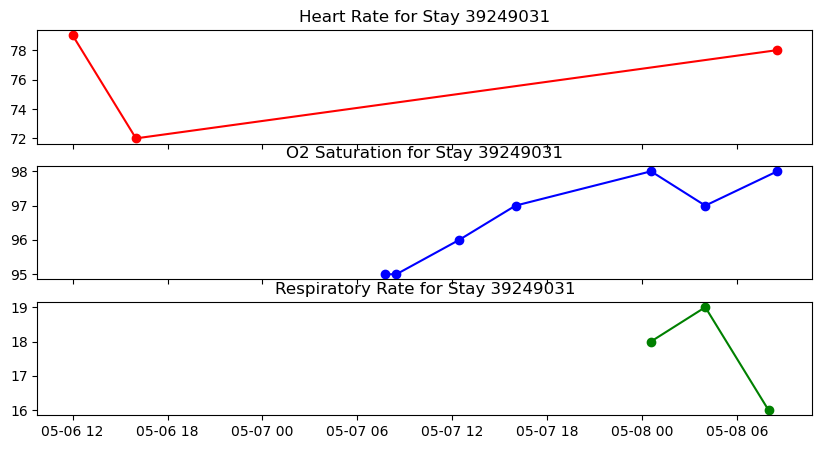

In [20]:
stay_id = 39249031
stay_data = df_vital[df_vital['stay_id']==stay_id]
stay_data_heartrate = stay_data[stay_data['variable']=='heart rate']
stay_data_o2 = stay_data[stay_data['variable']=='o2 saturation pulseoxymetry']
stay_data_respiratory_rate = stay_data[stay_data['variable']=='respiratory rate']

fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
axs[0].scatter(stay_data_heartrate['charttime'], stay_data_heartrate['value'], label='Heart Rate', color='red')
axs[0].plot(stay_data_heartrate['charttime'], stay_data_heartrate['value'], label='Heart Rate', color='red')
axs[0].set_title(f'Heart Rate for Stay {stay_id}')
axs[1].scatter(stay_data_o2['charttime'], stay_data_o2['value'], label='O2 Saturation', color='blue')
axs[1].plot(stay_data_o2['charttime'], stay_data_o2['value'], label='O2 Saturation', color='blue')
axs[1].set_title(f'O2 Saturation for Stay {stay_id}')
axs[2].scatter(stay_data_respiratory_rate['charttime'], stay_data_respiratory_rate['value'], label='Respiratory Rate', color='green')
axs[2].plot(stay_data_respiratory_rate['charttime'], stay_data_respiratory_rate['value'], label='Respiratory Rate', color='green')
axs[2].set_title(f'Respiratory Rate for Stay {stay_id}')
